In [2]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 51.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 54.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import os
import random
import math
import time
from pathlib import Path
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models.video import r3d_18  # 3D ResNet-18
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [4]:
# -------------------------
# CONFIG
# -------------------------
DATA_CSV = "final_metadata_clf.csv"        # your combined metadata (3600 rows)
IMAGE_KEY = "image"                    # column name with image path
LABEL_KEY = "label_3class"             # column name with numeric labels (0/1/2)
MASK_KEY = "mask"                      # optional mask path column
UID_KEY = "uid"

OUT_DIR = "runs/3d_resnet"
os.makedirs(OUT_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

In [6]:
# Model / training hyperparams
NUM_CLASSES = 3
BATCH_SIZE = 8              # reduce if GPU memory is limited
NUM_EPOCHS = 60
LR = 1e-4
WEIGHT_DECAY = 1e-5
NUM_WORKERS = 6
INPUT_SHAPE = (64, 64, 64)  # target patch shape (D,H,W) for the network
CROP_WITH_MASK = True       # If True, crop around mask bounding box then resize; else center-crop
USE_AMP = True              # mixed precision

# Augmentation params (applied on-the-fly in dataset)
AUG_PROB = 0.5
GAUSSIAN_NOISE_STD = 0.01


# Training utilities
BEST_MODEL_PATH = os.path.join(OUT_DIR, "best_model.pth")
LAST_MODEL_PATH = os.path.join(OUT_DIR, "last_model.pth")
LOG_CSV = os.path.join(OUT_DIR, "training_log.csv")


def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [7]:
# -------------------------
# HELPERS: load and preprocess
# -------------------------
def load_nii(path: str) -> np.ndarray:
    """Load nii.gz and return numpy array (Z,Y,X) or (D,H,W) as float32."""
    img = nib.load(path)
    arr = img.get_fdata(dtype=np.float32)
    # ensure shape ordering is (D,H,W) consistent with our use (z,y,x)
    # nibabel returns (X, Y, Z) depending — but in our pipeline arr.shape should be (H,W,D) often.
    # We will not transpose blindly; we assume your earlier pipeline ensured consistent orientation and shape.
    # If needed, adjust here.
    if arr.ndim == 4:
        arr = arr[..., 0]
    return arr.astype(np.float32)

def hu_windowing(img: np.ndarray, window_center: int = -600, window_width: int = 1500) -> np.ndarray:
    """Apply HU windowing typical for lung/CT. Adjust center/width if desired."""
    lower = window_center - window_width/2
    upper = window_center + window_width/2
    img = np.clip(img, lower, upper)
    img = (img - lower) / (upper - lower)  # normalize to 0..1
    return img

def resize_vol(vol: np.ndarray, target_shape: Tuple[int,int,int]) -> np.ndarray:
    """Resize using simple np interpolation via scipy if available, fallback to basic cropping/pad."""
    import scipy.ndimage as ndi
    factors = [t / s for s, t in zip(vol.shape, target_shape)]
    vol_resized = ndi.zoom(vol, zoom=factors, order=1)  # linear interpolation
    return vol_resized

def center_crop_or_pad(vol: np.ndarray, target_shape: Tuple[int,int,int]) -> np.ndarray:
    """Center-crop or pad to target_shape (D,H,W)."""
    out = np.zeros(target_shape, dtype=vol.dtype)
    dz, dh, dw = vol.shape
    td, th, tw = target_shape
    # compute start indices
    sd = max(0, (dz - td)//2)
    sh = max(0, (dh - th)//2)
    sw = max(0, (dw - tw)//2)
    ed = sd + min(td, dz)
    eh = sh + min(th, dh)
    ew = sw + min(tw, dw)
    out_sd = max(0, (td - dz)//2)
    out_sh = max(0, (th - dh)//2)
    out_sw = max(0, (tw - dw)//2)
    out[out_sd:out_sd+(ed-sd), out_sh:out_sh+(eh-sh), out_sw:out_sw+(ew-sw)] = vol[sd:ed, sh:eh, sw:ew]
    return out

def crop_around_mask(image: np.ndarray, mask: np.ndarray, margin: int = 6, target_shape: Tuple[int,int,int]=(64,64,64)) -> np.ndarray:
    """Crop tight bounding box around mask then center-pad/crop to target shape."""
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        # fallback to center crop
        return center_crop_or_pad(image, target_shape)
    zmin, ymin, xmin = coords.min(axis=0)
    zmax, ymax, xmax = coords.max(axis=0)
    zmin = max(0, zmin - margin); ymin = max(0, ymin - margin); xmin = max(0, xmin - margin)
    zmax = min(image.shape[0]-1, zmax + margin); ymax = min(image.shape[1]-1, ymax + margin); xmax = min(image.shape[2]-1, xmax + margin)
    cropped = image[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
    # resize or pad to target
    if cropped.shape != target_shape:
        cropped = resize_vol(cropped, target_shape)
    return cropped

In [8]:
# -------------------------
# DATASET
# -------------------------
class NiiDataset(Dataset):
    def __init__(self, df: pd.DataFrame, image_col: str = IMAGE_KEY, label_col: str = LABEL_KEY,
                 mask_col: Optional[str] = MASK_KEY, input_shape: Tuple[int,int,int]=INPUT_SHAPE,
                 augment: bool=True):
        self.df = df.reset_index(drop=True)
        self.image_col = image_col
        self.label_col = label_col
        self.mask_col = mask_col if mask_col in df.columns else None
        self.input_shape = input_shape
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def random_flip(self, vol: np.ndarray) -> np.ndarray:
        if random.random() < 0.5:
            # random axis flip
            axes = []
            if random.random() < 0.5: axes.append(0)
            if random.random() < 0.5: axes.append(1)
            if random.random() < 0.5: axes.append(2)
            for a in axes:
                vol = np.flip(vol, axis=a).copy()
        return vol

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row[self.image_col]
        label = int(row[self.label_col])

        img = load_nii(img_path)   # numpy (D,H,W)

        # apply HU windowing and normalization
        img = hu_windowing(img)    # values 0..1

        # optional mask-based crop for ROI
        if self.mask_col and pd.notna(row.get(self.mask_col, None)) and CROP_WITH_MASK:
            mask_path = row[self.mask_col]
            try:
                mask = load_nii(mask_path)
            except Exception:
                mask = np.zeros_like(img)
            img = crop_around_mask(img, mask, margin=6, target_shape=self.input_shape)
        else:
            # center crop/pad to desired shape, or resize
            if img.shape != self.input_shape:
                # try resize first if shapes are similar; else center crop/pad
                try:
                    img = resize_vol(img, self.input_shape)
                except Exception:
                    img = center_crop_or_pad(img, self.input_shape)

        # augmentations (on-the-fly)
        if self.augment:
            if random.random() < AUG_PROB:
                img = self.random_flip(img)
            if random.random() < AUG_PROB:
                # small intensity noise
                img = img + np.random.normal(0, GAUSSIAN_NOISE_STD, size=img.shape).astype(np.float32)
                img = np.clip(img, 0.0, 1.0)

        # standardize (0..1 -> mean/std)
        img = (img - img.mean()) / (img.std() + 1e-8)

        # convert to channel-first torch tensor: (C=1, D, H, W)
        tensor = torch.from_numpy(img).unsqueeze(0).float()

        return tensor, label

In [9]:
# -------------------------
# HELPERS: split + samplers
# -------------------------
def stratified_split(df: pd.DataFrame, val_frac: float = 0.15, seed: int = SEED):
    # simple stratified split by label_3class
    np.random.seed(seed)
    train_idxs = []
    val_idxs = []
    for lbl in sorted(df[LABEL_KEY].unique()):
        idxs = df[df[LABEL_KEY] == lbl].index.values
        np.random.shuffle(idxs)
        n_val = max(1, int(len(idxs) * val_frac))
        val_idxs.extend(list(idxs[:n_val]))
        train_idxs.extend(list(idxs[n_val:]))
    return df.loc[train_idxs].reset_index(drop=True), df.loc[val_idxs].reset_index(drop=True)

def make_weighted_sampler(df: pd.DataFrame, label_col: str = LABEL_KEY):
    labels = df[label_col].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    # weight for each class = 1 / count
    weight_per_class = 1.0 / class_sample_count
    weights = weight_per_class[labels]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    return sampler

In [10]:
# -------------------------
# MODEL
# -------------------------
def build_model(num_classes: int = NUM_CLASSES, pretrained: bool = False) -> nn.Module:
    model = r3d_18(pretrained=pretrained)
    # r3d_18 expects input (B, C=3, T, H, W). We have single-channel volumes; adjust first conv.
    # Replace conv1 to accept 1 channel
    old_conv = model.stem[0]
    new_conv = nn.Conv3d(1, old_conv.out_channels,
                         kernel_size=old_conv.kernel_size,
                         stride=old_conv.stride,
                         padding=old_conv.padding,
                         bias=False)
    # initialize from old conv by averaging weights across channels if pretrained available
    if pretrained:
        new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)
    model.stem[0] = new_conv

    # replace final FC
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [11]:
# -------------------------
# TRAIN & VALID LOOP
# -------------------------
def train_epoch(model, loader, criterion, optimizer, scaler=None):
    model.train()
    losses = []
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="Train", leave=False)
    for x, y in pbar:
        x = x.to(DEVICE)
        y = y.to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()
        if USE_AMP and scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        preds = logits.detach().argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y.cpu().numpy())
        pbar.set_postfix(loss=np.mean(losses), acc=accuracy_score(all_targets, all_preds))

    return np.mean(losses), all_targets, all_preds


def validate_epoch(model, loader, criterion):
    model.eval()
    losses = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Valid", leave=False)
        for x, y in pbar:
            x = x.to(DEVICE)
            y = y.to(DEVICE, dtype=torch.long)
            logits = model(x)
            loss = criterion(logits, y)
            losses.append(loss.item())
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(y.cpu().numpy())
            pbar.set_postfix(loss=np.mean(losses), acc=accuracy_score(all_targets, all_preds))
    return np.mean(losses), all_targets, all_preds

In [12]:
# -------------------------
# MAIN
# -------------------------
def main():
    df = pd.read_csv(DATA_CSV)
    # ensure labels are integers 0..2
    if df[LABEL_KEY].dtype != int and df[LABEL_KEY].dtype != np.int64:
        df[LABEL_KEY] = df[LABEL_KEY].astype(int)

    # split
    train_df, val_df = stratified_split(df, val_frac=0.15)
    print("Train:", len(train_df), "Val:", len(val_df))

    # datasets
    train_ds = NiiDataset(train_df, augment=True)
    val_ds   = NiiDataset(val_df, augment=False)

    # sampler to rebalance within each epoch
    sampler = make_weighted_sampler(train_df)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=True)

    model = build_model(num_classes=NUM_CLASSES, pretrained=False).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and DEVICE.startswith("cuda"))

    best_val_loss = 1e9
    logs = []

    for epoch in range(1, NUM_EPOCHS+1):
        t0 = time.time()
        train_loss, train_targets, train_preds = train_epoch(model, train_loader, criterion, optimizer, scaler)
        val_loss, val_targets, val_preds = validate_epoch(model, val_loader, criterion)
        scheduler.step()

        # metrics
        train_acc = accuracy_score(train_targets, train_preds)
        val_acc = accuracy_score(val_targets, val_preds)
        p, r, f1, _ = precision_recall_fscore_support(val_targets, val_preds, average='weighted', zero_division=0)
        cm = confusion_matrix(val_targets, val_preds)

        elapsed = time.time() - t0
        print(f"Epoch {epoch}/{NUM_EPOCHS} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f} time={elapsed:.1f}s")
        print("Val: precision, recall, f1 (weighted):", f"{p:.4f}, {r:.4f}, {f1:.4f}")
        print("Confusion matrix:\n", cm)

        logs.append({
            "epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
            "train_acc": train_acc, "val_acc": val_acc, "precision": p, "recall": r, "f1": f1
        })
        pd.DataFrame(logs).to_csv(LOG_CSV, index=False)

        # save last
        torch.save({"epoch": epoch, "model_state": model.state_dict(), "optimizer": optimizer.state_dict()},
                   LAST_MODEL_PATH)

        # save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({"epoch": epoch, "model_state": model.state_dict(), "optimizer": optimizer.state_dict()},
                       BEST_MODEL_PATH)
            print("=> saved best model")

    print("Training finished. Best val loss:", best_val_loss)
    print("Best model saved to:", BEST_MODEL_PATH)

In [13]:
main()

Train: 3060 Val: 540


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/60 | train_loss=0.9464 val_loss=0.7126 train_acc=0.5356 val_acc=0.7463 time=24.2s
Val: precision, recall, f1 (weighted): 0.7751, 0.7463, 0.7466
Confusion matrix:
 [[156  24   0]
 [ 38 133   9]
 [ 44  22 114]]
=> saved best model


Epoch 2/60 | train_loss=0.8555 val_loss=0.6532 train_acc=0.5941 val_acc=0.7630 time=23.2s
Val: precision, recall, f1 (weighted): 0.7792, 0.7630, 0.7622
Confusion matrix:
 [[160  15   5]
 [ 41 119  20]
 [ 36  11 133]]
=> saved best model


Epoch 3/60 | train_loss=0.7967 val_loss=0.6076 train_acc=0.6542 val_acc=0.7630 time=23.6s
Val: precision, recall, f1 (weighted): 0.7646, 0.7630, 0.7634
Confusion matrix:
 [[139  37   4]
 [ 18 135  27]
 [ 27  15 138]]
=> saved best model


Epoch 4/60 | train_loss=0.7558 val_loss=0.6051 train_acc=0.6631 val_acc=0.7907 time=23.7s
Val: precision, recall, f1 (weighted): 0.8156, 0.7907, 0.7886
Confusion matrix:
 [[173   7   0]
 [ 40 118  22]
 [ 37   7 136]]
=> saved best model


Epoch 5/60 | train_loss=0.7215 val_loss=0.6805 train_acc=0.6895 val_acc=0.7352 time=23.8s
Val: precision, recall, f1 (weighted): 0.7686, 0.7352, 0.7383
Confusion matrix:
 [[117  62   1]
 [ 16 154  10]
 [ 18  36 126]]


Epoch 6/60 | train_loss=0.7113 val_loss=0.5478 train_acc=0.6987 val_acc=0.8093 time=23.7s
Val: precision, recall, f1 (weighted): 0.8131, 0.8093, 0.8086
Confusion matrix:
 [[160  14   6]
 [ 24 134  22]
 [ 25  12 143]]
=> saved best model


Epoch 7/60 | train_loss=0.7179 val_loss=0.5269 train_acc=0.6938 val_acc=0.8222 time=23.9s
Val: precision, recall, f1 (weighted): 0.8329, 0.8222, 0.8205
Confusion matrix:
 [[173   6   1]
 [ 27 136  17]
 [ 29  16 135]]
=> saved best model


Epoch 8/60 | train_loss=0.7014 val_loss=0.5477 train_acc=0.7026 val_acc=0.7685 time=24.0s
Val: precision, recall, f1 (weighted): 0.7748, 0.7685, 0.7697
Confusion matrix:
 [[137  38   5]
 [ 20 142  18]
 [ 21  23 136]]


Epoch 9/60 | train_loss=0.6617 val_loss=0.5316 train_acc=0.7225 val_acc=0.8093 time=23.9s
Val: precision, recall, f1 (weighted): 0.8238, 0.8093, 0.8079
Confusion matrix:
 [[171   8   1]
 [ 34 129  17]
 [ 30  13 137]]


Epoch 10/60 | train_loss=0.6596 val_loss=0.5691 train_acc=0.7180 val_acc=0.8167 time=23.8s
Val: precision, recall, f1 (weighted): 0.8335, 0.8167, 0.8163
Confusion matrix:
 [[170  10   0]
 [ 31 131  18]
 [ 34   6 140]]


Epoch 11/60 | train_loss=0.6623 val_loss=0.5951 train_acc=0.7258 val_acc=0.8111 time=23.6s
Val: precision, recall, f1 (weighted): 0.8359, 0.8111, 0.8101
Confusion matrix:
 [[176   4   0]
 [ 35 132  13]
 [ 38  12 130]]


Epoch 12/60 | train_loss=0.6283 val_loss=0.5809 train_acc=0.7441 val_acc=0.8037 time=23.7s
Val: precision, recall, f1 (weighted): 0.8280, 0.8037, 0.8012
Confusion matrix:
 [[176   4   0]
 [ 36 137   7]
 [ 33  26 121]]


Epoch 13/60 | train_loss=0.6232 val_loss=0.5785 train_acc=0.7412 val_acc=0.7981 time=23.9s
Val: precision, recall, f1 (weighted): 0.8237, 0.7981, 0.7969
Confusion matrix:
 [[174   6   0]
 [ 36 132  12]
 [ 40  15 125]]


Epoch 14/60 | train_loss=0.6519 val_loss=0.5673 train_acc=0.7265 val_acc=0.7870 time=23.8s
Val: precision, recall, f1 (weighted): 0.8126, 0.7870, 0.7842
Confusion matrix:
 [[173   7   0]
 [ 35 136   9]
 [ 39  25 116]]


Epoch 15/60 | train_loss=0.6163 val_loss=0.4703 train_acc=0.7444 val_acc=0.8537 time=23.8s
Val: precision, recall, f1 (weighted): 0.8667, 0.8537, 0.8528
Confusion matrix:
 [[177   3   0]
 [ 24 145  11]
 [ 28  13 139]]
=> saved best model


Epoch 16/60 | train_loss=0.5840 val_loss=0.4697 train_acc=0.7569 val_acc=0.8370 time=23.8s
Val: precision, recall, f1 (weighted): 0.8514, 0.8370, 0.8354
Confusion matrix:
 [[177   3   0]
 [ 31 132  17]
 [ 26  11 143]]
=> saved best model


Epoch 17/60 | train_loss=0.5978 val_loss=0.4418 train_acc=0.7395 val_acc=0.8574 time=23.7s
Val: precision, recall, f1 (weighted): 0.8652, 0.8574, 0.8555
Confusion matrix:
 [[177   3   0]
 [ 20 150  10]
 [ 21  23 136]]
=> saved best model


Epoch 18/60 | train_loss=0.5848 val_loss=0.4084 train_acc=0.7631 val_acc=0.8556 time=23.6s
Val: precision, recall, f1 (weighted): 0.8601, 0.8556, 0.8543
Confusion matrix:
 [[173   5   2]
 [ 19 142  19]
 [ 21  12 147]]
=> saved best model


Epoch 19/60 | train_loss=0.5759 val_loss=0.4126 train_acc=0.7654 val_acc=0.8556 time=23.5s
Val: precision, recall, f1 (weighted): 0.8558, 0.8556, 0.8551
Confusion matrix:
 [[165  14   1]
 [ 10 149  21]
 [ 18  14 148]]


Epoch 20/60 | train_loss=0.5494 val_loss=0.4185 train_acc=0.7716 val_acc=0.8556 time=23.5s
Val: precision, recall, f1 (weighted): 0.8569, 0.8556, 0.8542
Confusion matrix:
 [[172   6   2]
 [ 15 143  22]
 [ 18  15 147]]


Epoch 21/60 | train_loss=0.5503 val_loss=0.4214 train_acc=0.7716 val_acc=0.8519 time=23.5s
Val: precision, recall, f1 (weighted): 0.8539, 0.8519, 0.8500
Confusion matrix:
 [[174   5   1]
 [ 20 140  20]
 [ 16  18 146]]


Epoch 22/60 | train_loss=0.5516 val_loss=0.4431 train_acc=0.7676 val_acc=0.8352 time=23.5s
Val: precision, recall, f1 (weighted): 0.8352, 0.8352, 0.8352
Confusion matrix:
 [[154  13  13]
 [ 12 149  19]
 [ 15  17 148]]


Epoch 23/60 | train_loss=0.5307 val_loss=0.4641 train_acc=0.7788 val_acc=0.8500 time=23.7s
Val: precision, recall, f1 (weighted): 0.8545, 0.8500, 0.8490
Confusion matrix:
 [[170  10   0]
 [ 17 149  14]
 [ 21  19 140]]


Epoch 24/60 | train_loss=0.5412 val_loss=0.3964 train_acc=0.7742 val_acc=0.8519 time=23.5s
Val: precision, recall, f1 (weighted): 0.8539, 0.8519, 0.8517
Confusion matrix:
 [[160  16   4]
 [ 10 156  14]
 [ 16  20 144]]
=> saved best model


Epoch 25/60 | train_loss=0.5371 val_loss=0.4127 train_acc=0.7797 val_acc=0.8667 time=23.3s
Val: precision, recall, f1 (weighted): 0.8691, 0.8667, 0.8648
Confusion matrix:
 [[176   3   1]
 [ 14 152  14]
 [ 17  23 140]]


Epoch 26/60 | train_loss=0.5054 val_loss=0.3946 train_acc=0.7948 val_acc=0.8648 time=23.5s
Val: precision, recall, f1 (weighted): 0.8664, 0.8648, 0.8638
Confusion matrix:
 [[172   7   1]
 [ 15 147  18]
 [ 17  15 148]]
=> saved best model


Epoch 27/60 | train_loss=0.4953 val_loss=0.3670 train_acc=0.7997 val_acc=0.8778 time=23.6s
Val: precision, recall, f1 (weighted): 0.8817, 0.8778, 0.8769
Confusion matrix:
 [[175   0   5]
 [ 15 148  17]
 [ 18  11 151]]
=> saved best model


Epoch 28/60 | train_loss=0.4689 val_loss=0.3662 train_acc=0.8154 val_acc=0.8759 time=23.6s
Val: precision, recall, f1 (weighted): 0.8762, 0.8759, 0.8751
Confusion matrix:
 [[172   1   7]
 [ 10 151  19]
 [ 14  16 150]]
=> saved best model


Epoch 29/60 | train_loss=0.4852 val_loss=0.4107 train_acc=0.7951 val_acc=0.8648 time=23.5s
Val: precision, recall, f1 (weighted): 0.8682, 0.8648, 0.8634
Confusion matrix:
 [[174   1   5]
 [ 16 141  23]
 [ 16  12 152]]


Epoch 30/60 | train_loss=0.4818 val_loss=0.4015 train_acc=0.8016 val_acc=0.8667 time=23.6s
Val: precision, recall, f1 (weighted): 0.8731, 0.8667, 0.8658
Confusion matrix:
 [[171   1   8]
 [ 14 139  27]
 [ 15   7 158]]


Epoch 31/60 | train_loss=0.4667 val_loss=0.3899 train_acc=0.8046 val_acc=0.8574 time=23.6s
Val: precision, recall, f1 (weighted): 0.8590, 0.8574, 0.8574
Confusion matrix:
 [[161  13   6]
 [  6 157  17]
 [ 11  24 145]]


Epoch 32/60 | train_loss=0.4816 val_loss=0.3815 train_acc=0.7990 val_acc=0.8796 time=23.5s
Val: precision, recall, f1 (weighted): 0.8805, 0.8796, 0.8780
Confusion matrix:
 [[178   2   0]
 [ 13 149  18]
 [ 14  18 148]]


Epoch 33/60 | train_loss=0.4759 val_loss=0.3639 train_acc=0.8072 val_acc=0.8685 time=23.5s
Val: precision, recall, f1 (weighted): 0.8731, 0.8685, 0.8659
Confusion matrix:
 [[177   2   1]
 [ 11 159  10]
 [ 16  31 133]]
=> saved best model


Epoch 34/60 | train_loss=0.4521 val_loss=0.3896 train_acc=0.8141 val_acc=0.8796 time=23.5s
Val: precision, recall, f1 (weighted): 0.8814, 0.8796, 0.8781
Confusion matrix:
 [[176   3   1]
 [ 10 156  14]
 [ 18  19 143]]


Epoch 35/60 | train_loss=0.4640 val_loss=0.3371 train_acc=0.8049 val_acc=0.8907 time=23.6s
Val: precision, recall, f1 (weighted): 0.8927, 0.8907, 0.8887
Confusion matrix:
 [[178   1   1]
 [  6 163  11]
 [ 16  24 140]]
=> saved best model


Epoch 36/60 | train_loss=0.4460 val_loss=0.3342 train_acc=0.8082 val_acc=0.9000 time=23.6s
Val: precision, recall, f1 (weighted): 0.9001, 0.9000, 0.8987
Confusion matrix:
 [[179   0   1]
 [  8 157  15]
 [ 12  18 150]]
=> saved best model


Epoch 37/60 | train_loss=0.4570 val_loss=0.3545 train_acc=0.8147 val_acc=0.8815 time=23.5s
Val: precision, recall, f1 (weighted): 0.8828, 0.8815, 0.8801
Confusion matrix:
 [[177   2   1]
 [ 10 149  21]
 [ 17  13 150]]


Epoch 38/60 | train_loss=0.4286 val_loss=0.3624 train_acc=0.8252 val_acc=0.8852 time=23.6s
Val: precision, recall, f1 (weighted): 0.8871, 0.8852, 0.8838
Confusion matrix:
 [[177   0   3]
 [ 12 144  24]
 [ 11  12 157]]


Epoch 39/60 | train_loss=0.4540 val_loss=0.3534 train_acc=0.8095 val_acc=0.8889 time=23.5s
Val: precision, recall, f1 (weighted): 0.8885, 0.8889, 0.8879
Confusion matrix:
 [[175   0   5]
 [  9 156  15]
 [ 11  20 149]]


Epoch 40/60 | train_loss=0.4044 val_loss=0.3186 train_acc=0.8310 val_acc=0.8889 time=23.6s
Val: precision, recall, f1 (weighted): 0.8890, 0.8889, 0.8883
Confusion matrix:
 [[171   5   4]
 [  4 161  15]
 [ 10  22 148]]
=> saved best model


Epoch 41/60 | train_loss=0.4258 val_loss=0.3468 train_acc=0.8278 val_acc=0.8889 time=23.5s
Val: precision, recall, f1 (weighted): 0.8903, 0.8889, 0.8872
Confusion matrix:
 [[178   1   1]
 [  9 159  12]
 [ 13  24 143]]


Epoch 42/60 | train_loss=0.4266 val_loss=0.3265 train_acc=0.8235 val_acc=0.8778 time=23.5s
Val: precision, recall, f1 (weighted): 0.8772, 0.8778, 0.8768
Confusion matrix:
 [[174   2   4]
 [  9 149  22]
 [ 11  18 151]]


Epoch 43/60 | train_loss=0.4047 val_loss=0.3218 train_acc=0.8337 val_acc=0.8889 time=23.6s
Val: precision, recall, f1 (weighted): 0.8886, 0.8889, 0.8880
Confusion matrix:
 [[175   2   3]
 [  7 152  21]
 [ 12  15 153]]


Epoch 44/60 | train_loss=0.4159 val_loss=0.3587 train_acc=0.8301 val_acc=0.8778 time=23.6s
Val: precision, recall, f1 (weighted): 0.8776, 0.8778, 0.8761
Confusion matrix:
 [[178   0   2]
 [ 10 149  21]
 [ 14  19 147]]


Epoch 45/60 | train_loss=0.4147 val_loss=0.3348 train_acc=0.8275 val_acc=0.8926 time=23.4s
Val: precision, recall, f1 (weighted): 0.8922, 0.8926, 0.8914
Confusion matrix:
 [[177   1   2]
 [  7 157  16]
 [ 12  20 148]]


Epoch 46/60 | train_loss=0.4063 val_loss=0.3331 train_acc=0.8343 val_acc=0.8889 time=23.5s
Val: precision, recall, f1 (weighted): 0.8883, 0.8889, 0.8874
Confusion matrix:
 [[178   0   2]
 [  6 155  19]
 [ 14  19 147]]


Epoch 47/60 | train_loss=0.4123 val_loss=0.3251 train_acc=0.8216 val_acc=0.8852 time=23.5s
Val: precision, recall, f1 (weighted): 0.8843, 0.8852, 0.8839
Confusion matrix:
 [[177   2   1]
 [  8 149  23]
 [ 10  18 152]]


Epoch 48/60 | train_loss=0.3915 val_loss=0.3121 train_acc=0.8425 val_acc=0.9056 time=23.6s
Val: precision, recall, f1 (weighted): 0.9050, 0.9056, 0.9044
Confusion matrix:
 [[178   1   1]
 [  2 162  16]
 [ 13  18 149]]
=> saved best model


Epoch 49/60 | train_loss=0.3766 val_loss=0.3224 train_acc=0.8448 val_acc=0.8944 time=23.4s
Val: precision, recall, f1 (weighted): 0.8941, 0.8944, 0.8934
Confusion matrix:
 [[177   0   3]
 [  6 155  19]
 [ 13  16 151]]


Epoch 50/60 | train_loss=0.3917 val_loss=0.3151 train_acc=0.8373 val_acc=0.8963 time=23.5s
Val: precision, recall, f1 (weighted): 0.8962, 0.8963, 0.8950
Confusion matrix:
 [[177   1   2]
 [  5 161  14]
 [ 12  22 146]]


Epoch 51/60 | train_loss=0.3653 val_loss=0.3108 train_acc=0.8533 val_acc=0.8963 time=23.6s
Val: precision, recall, f1 (weighted): 0.8965, 0.8963, 0.8947
Confusion matrix:
 [[178   0   2]
 [  5 162  13]
 [ 13  23 144]]
=> saved best model


Epoch 52/60 | train_loss=0.3992 val_loss=0.2998 train_acc=0.8337 val_acc=0.9000 time=23.4s
Val: precision, recall, f1 (weighted): 0.8993, 0.9000, 0.8988
Confusion matrix:
 [[178   0   2]
 [  4 160  16]
 [ 12  20 148]]
=> saved best model


Epoch 53/60 | train_loss=0.3699 val_loss=0.2917 train_acc=0.8546 val_acc=0.9000 time=23.5s
Val: precision, recall, f1 (weighted): 0.8993, 0.9000, 0.8990
Confusion matrix:
 [[178   0   2]
 [  5 156  19]
 [ 11  17 152]]
=> saved best model


Epoch 54/60 | train_loss=0.4089 val_loss=0.3069 train_acc=0.8327 val_acc=0.8963 time=23.5s
Val: precision, recall, f1 (weighted): 0.8957, 0.8963, 0.8951
Confusion matrix:
 [[178   0   2]
 [  6 157  17]
 [ 12  19 149]]


Epoch 55/60 | train_loss=0.3683 val_loss=0.3073 train_acc=0.8435 val_acc=0.9037 time=23.4s
Val: precision, recall, f1 (weighted): 0.9029, 0.9037, 0.9026
Confusion matrix:
 [[178   0   2]
 [  3 161  16]
 [ 11  20 149]]


Epoch 56/60 | train_loss=0.3960 val_loss=0.3046 train_acc=0.8402 val_acc=0.9074 time=23.5s
Val: precision, recall, f1 (weighted): 0.9072, 0.9074, 0.9061
Confusion matrix:
 [[178   0   2]
 [  2 165  13]
 [ 13  20 147]]


Epoch 57/60 | train_loss=0.3728 val_loss=0.3130 train_acc=0.8542 val_acc=0.8944 time=23.6s
Val: precision, recall, f1 (weighted): 0.8948, 0.8944, 0.8929
Confusion matrix:
 [[178   0   2]
 [  6 160  14]
 [ 16  19 145]]


Epoch 58/60 | train_loss=0.3599 val_loss=0.3023 train_acc=0.8523 val_acc=0.9037 time=23.5s
Val: precision, recall, f1 (weighted): 0.9036, 0.9037, 0.9024
Confusion matrix:
 [[178   0   2]
 [  4 163  13]
 [ 13  20 147]]


Epoch 59/60 | train_loss=0.3896 val_loss=0.3131 train_acc=0.8402 val_acc=0.8944 time=23.5s
Val: precision, recall, f1 (weighted): 0.8947, 0.8944, 0.8930
Confusion matrix:
 [[178   0   2]
 [  7 159  14]
 [ 14  20 146]]


Epoch 60/60 | train_loss=0.3638 val_loss=0.2932 train_acc=0.8510 val_acc=0.9111 time=23.5s
Val: precision, recall, f1 (weighted): 0.9106, 0.9111, 0.9100
Confusion matrix:
 [[178   0   2]
 [  1 165  14]
 [ 11  20 149]]
Training finished. Best val loss: 0.2916750796892516
Best model saved to: runs/3d_resnet/best_model.pth


Found 2516 augmented samples.


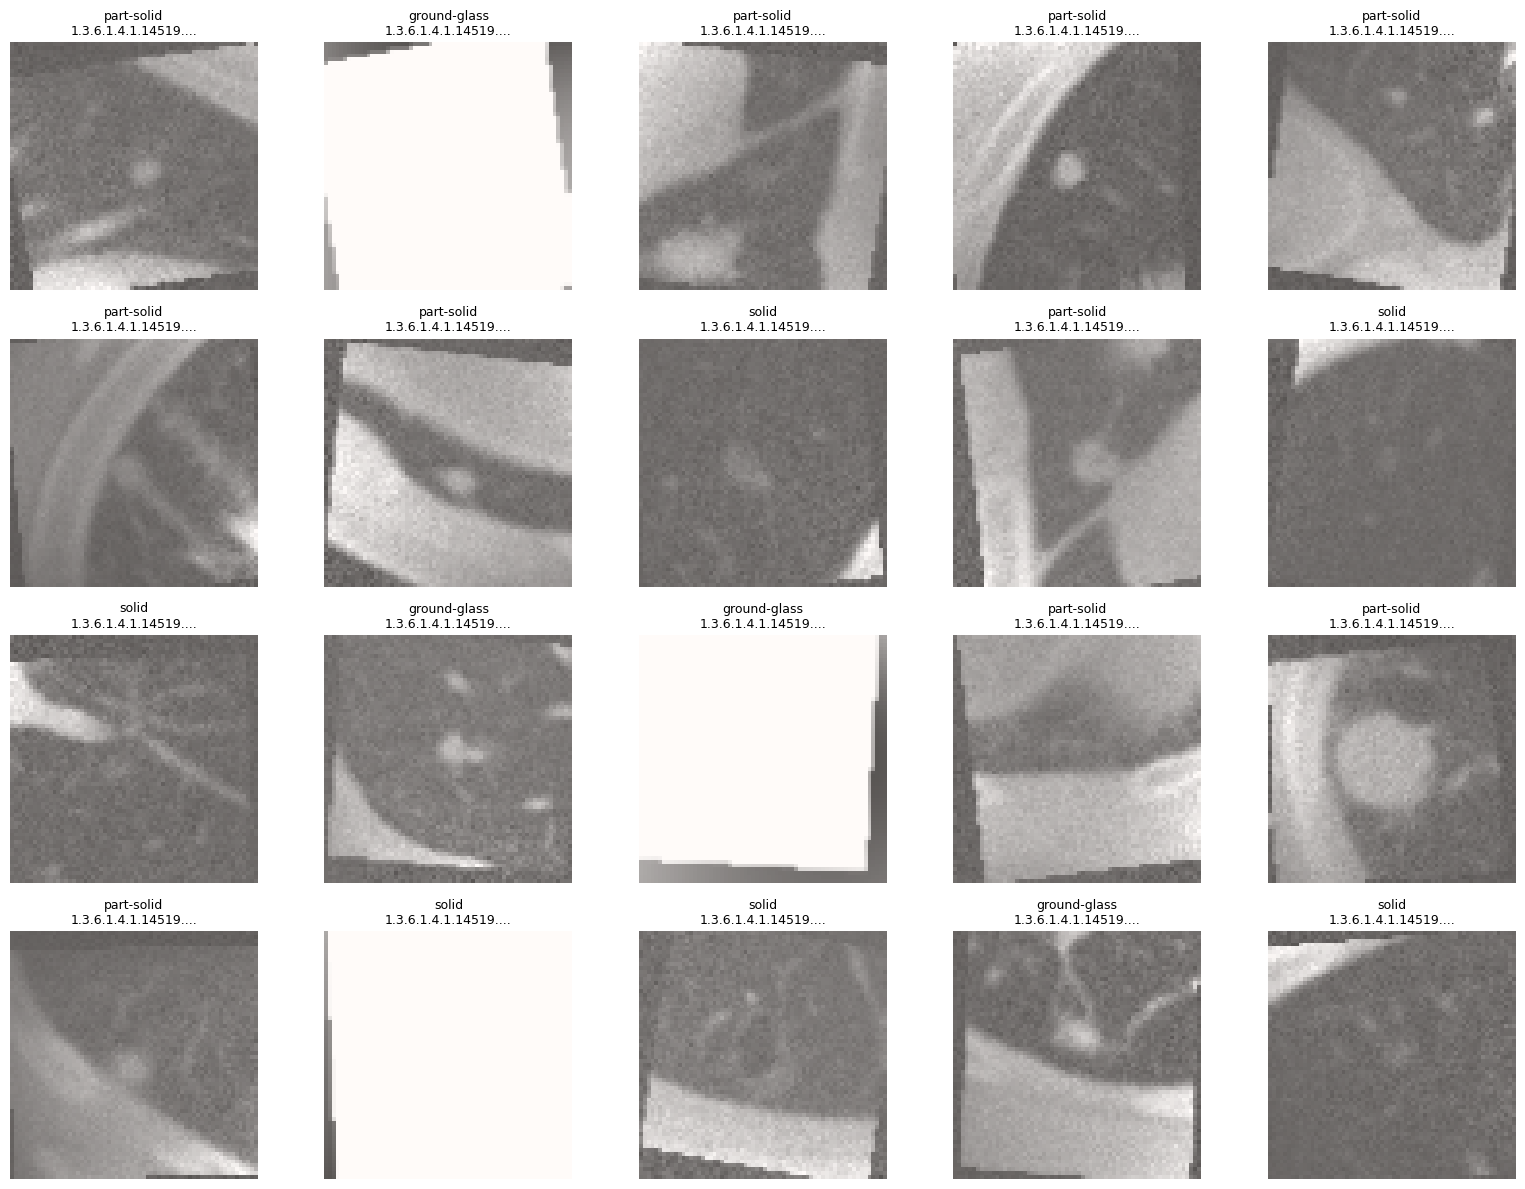

In [14]:
import os
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

AUG_DIR = "preprocessed_fleischner_fixed/augmented"
CLASSES = ["ground-glass", "part-solid", "solid"]

def load_nii(path):
    return nib.load(path).get_fdata()

# ------------------------------
# COLLECT ALL AUGMENTED SAMPLES
# ------------------------------
samples = []

for cls in CLASSES:
    class_dir = os.path.join(AUG_DIR, cls)
    for f in os.listdir(class_dir):
        if f.endswith(".nii.gz") and "_aug_" in f and not f.endswith("_mask.nii.gz"):
            img_path = os.path.join(class_dir, f)
            mask_path = img_path.replace(".nii.gz", "_mask.nii.gz")
            samples.append((cls, img_path, mask_path))

print(f"Found {len(samples)} augmented samples.")

# RANDOMLY SELECT 20
chosen = random.sample(samples, 20)

# ------------------------------
# VISUALIZE IN 4 × 5 GRID
# ------------------------------
fig, axes = plt.subplots(4, 5, figsize=(16, 12))
axes = axes.flatten()

for ax, (cls, img_path, mask_path) in zip(axes, chosen):

    # Load CT & mask
    img = load_nii(img_path)
    mask = load_nii(mask_path)

    # Pick center slice along Z-axis
    z = img.shape[2] // 2
    img_slice = img[:, :, z]
    mask_slice = mask[:, :, z]

    # Normalize image for display
    img_disp = img_slice
    if img_disp.max() > 0:
        img_disp = img_disp / img_disp.max()

    # Plot
    ax.imshow(img_disp, cmap="gray")
    ax.imshow(mask_slice, alpha=0.35, cmap="Reds")  # overlay

    title = f"{cls}\n{os.path.basename(img_path)[:18]}..."
    ax.set_title(title, fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()


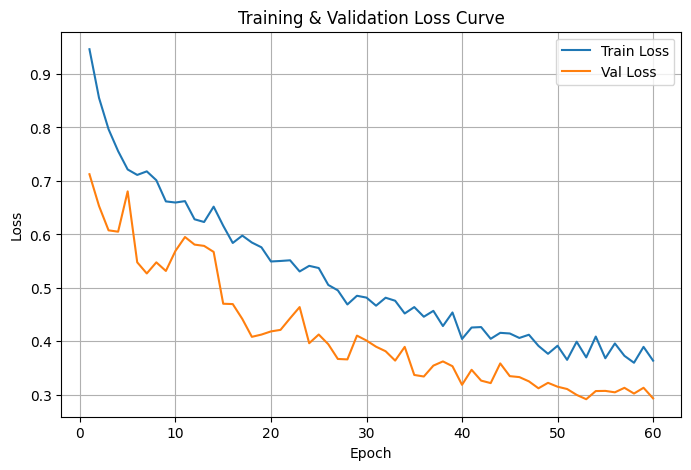

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv("runs/3d_resnet/training_log.csv")

plt.figure(figsize=(8,5))
plt.plot(log["epoch"], log["train_loss"], label="Train Loss")
plt.plot(log["epoch"], log["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve_resnet.png", dpi=300, bbox_inches='tight')
plt.show()


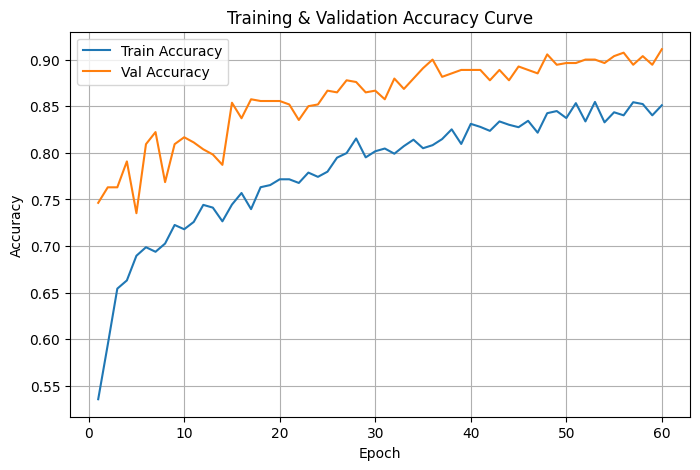

In [25]:
plt.figure(figsize=(8,5))
plt.plot(log["epoch"], log["train_acc"], label="Train Accuracy")
plt.plot(log["epoch"], log["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Curve")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_curve.png", dpi=300, bbox_inches='tight')
plt.show()


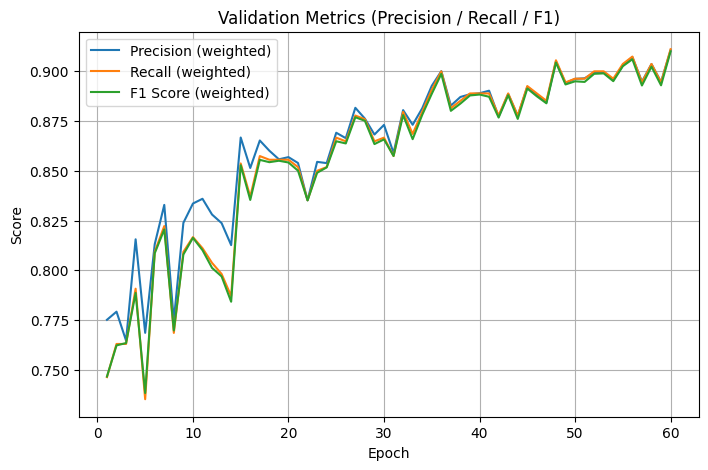

In [26]:
plt.figure(figsize=(8,5))
plt.plot(log["epoch"], log["precision"], label="Precision (weighted)")
plt.plot(log["epoch"], log["recall"], label="Recall (weighted)")
plt.plot(log["epoch"], log["f1"], label="F1 Score (weighted)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics (Precision / Recall / F1)")
plt.legend()
plt.grid(True)
plt.savefig("metrics_curve.png", dpi=300, bbox_inches='tight')
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


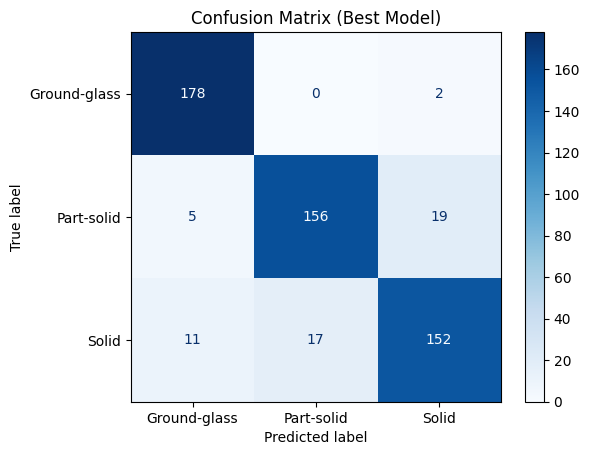

              precision    recall  f1-score   support

Ground-glass       0.92      0.99      0.95       180
  Part-solid       0.90      0.87      0.88       180
       Solid       0.88      0.84      0.86       180

    accuracy                           0.90       540
   macro avg       0.90      0.90      0.90       540
weighted avg       0.90      0.90      0.90       540



In [27]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# Load metadata
# -----------------------
df = pd.read_csv("final_metadata_clf.csv")

# Load your split function if needed
def stratified_split(df, val_frac=0.15, seed=42):
    import numpy as np
    np.random.seed(seed)
    train_idxs, val_idxs = [], []
    
    for lbl in sorted(df["label_3class"].unique()):
        idxs = df[df["label_3class"] == lbl].index.values
        np.random.shuffle(idxs)
        n_val = int(len(idxs) * val_frac)
        val_idxs.extend(idxs[:n_val])
        train_idxs.extend(idxs[n_val:])
    return df.loc[train_idxs], df.loc[val_idxs]

_, val_df = stratified_split(df)

# -----------------------
# Dataset + Dataloader
# -----------------------
val_ds = NiiDataset(val_df, augment=False)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

# -----------------------
# Load best model
# -----------------------
checkpoint = torch.load("runs/3d_resnet/best_model.pth", map_location="cuda")
model = build_model(num_classes=3)
model.load_state_dict(checkpoint["model_state"])
model = model.to("cuda")
model.eval()

# -----------------------
# Run validation again
# -----------------------
val_targets = []
val_preds = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to("cuda")
        y = y.to("cuda")
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        val_preds.extend(preds)
        val_targets.extend(y.cpu().numpy())

# -----------------------
# Confusion Matrix
# -----------------------
cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Ground-glass", "Part-solid", "Solid"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Best Model)")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print(classification_report(val_targets, val_preds, target_names=["Ground-glass", "Part-solid", "Solid"]))



In [30]:
def get_accuracy_score(model_name,y_test, y_predicted):
  accuracy = accuracy_score(y_test, y_predicted)
  print(f"{model_name} Model Accuracy: {round(accuracy*100,2)} %")
  return round(accuracy*100,2)

def generate_classification_report(y_test, y_predicted):
  report = classification_report(y_test, y_predicted, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  return report_df

In [28]:
get_accuracy_score('ResNet18',val_targets,val_preds)

ResNet18 Model Accuracy: 90.0 %


90.0

In [29]:
generate_classification_report(val_targets,val_preds)

,precision,recall,f1-score,support
0,0.917526,0.988889,0.951872,180.0
1,0.901734,0.866667,0.883853,180.0
2,0.878613,0.844444,0.861190,180.0
accuracy,0.900000,0.900000,0.900000,0.9
macro avg,0.899291,0.900000,0.898971,540.0
weighted avg,0.899291,0.900000,0.898971,540.0
